In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-01-10 16:35:30.292196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the datasets
train_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/train2.csv')
test_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/test2.csv')

# Convert the 'local_time' column to pandas datetime type
train_data['local_time'] = pd.to_datetime(train_data['local_time'])
test_data['local_time'] = pd.to_datetime(test_data['local_time'])

# Save local_time for plotting before dropping it
datetime_test = test_data['local_time'].copy()


In [3]:
# Convert the 'local_time' column to pandas datetime type
train_data['local_time'] = pd.to_datetime(train_data['local_time'])
test_data['local_time'] = pd.to_datetime(test_data['local_time'])

# Extract features from the local_time column
for df in [train_data, test_data]:
    df['Year'] = df['local_time'].dt.year
    df['Month'] = df['local_time'].dt.month
    df['Day'] = df['local_time'].dt.day
    df['Hour'] = df['local_time'].dt.hour

# Drop the original local_time column as it's not needed anymore
train_data.drop('local_time', axis=1, inplace=True)
test_data.drop('local_time', axis=1, inplace=True)

# Include 'Average_Temp' in the feature set
X_train = train_data[['Year', 'Month', 'Day', 'Hour', 'Average_Temp']]
y_train = train_data['MW']
X_test = test_data[['Year', 'Month', 'Day', 'Hour', 'Average_Temp']]
y_test = test_data['MW']

# Make a copy of the datasets for LEAR and DNN
X_train_lear = X_train.copy()
X_test_lear = X_test.copy()
X_train_dnn = X_train.copy()
X_test_dnn = X_test.copy()

In [4]:
# Linear Regression model
lear_model = LinearRegression()
lear_model.fit(X_train_lear, y_train)


LinearRegression()

In [5]:
# DNN model
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dnn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

dnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
dnn_model.fit(X_train_dnn, y_train, epochs=10, batch_size=32)


Epoch 1/10
548/548 [==============================] - 2s 2ms/step - loss: 4628.7915
Epoch 2/10
548/548 [==============================] - 1s 2ms/step - loss: 4080.6936
Epoch 3/10
548/548 [==============================] - 1s 2ms/step - loss: 3752.6855
Epoch 4/10
548/548 [==============================] - 1s 2ms/step - loss: 3685.6338
Epoch 5/10
548/548 [==============================] - 1s 2ms/step - loss: 3633.7136
Epoch 6/10
548/548 [==============================] - 1s 2ms/step - loss: 3537.5183
Epoch 7/10
548/548 [==============================] - 1s 2ms/step - loss: 3528.1348
Epoch 8/10
548/548 [==============================] - 1s 2ms/step - loss: 3546.8035
Epoch 9/10
548/548 [==============================] - 1s 2ms/step - loss: 3509.9775
Epoch 10/10
548/548 [==============================] - 1s 2ms/step - loss: 3433.4221


In [6]:
# Predictions from LEAR
lear_predictions = lear_model.predict(X_test_lear)

# Predictions from DNN
dnn_predictions = dnn_model.predict(X_test_dnn).flatten()


274/274 [==============================] - 0s 1ms/step


In [7]:
# Combine actual and predicted values in a DataFrame
results_comparison = pd.DataFrame({
    'Actual': y_test,
    'LEAR Predictions': lear_predictions,
    'DNN Predictions': dnn_predictions
})


In [8]:
print(results_comparison)

         Actual  LEAR Predictions  DNN Predictions
0     117.83241        152.051771       132.031754
1     119.51455         71.600456        20.361940
2     114.00266         73.559726        21.503881
3     112.82553         75.502795        22.643118
4     108.65000         77.092682        23.723761
...         ...               ...              ...
8756   50.05301        182.897903       126.075714
8757   50.08335        184.688682       128.592712
8758   49.23503        186.354715       130.680542
8759   46.34927        187.913820       132.447556
8760   45.81851        189.704600       134.891449

[8761 rows x 3 columns]


In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, predicted, threshold=1.0, mape_error_threshold=200):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Filter out pairs where the actual value is above the threshold and percentage error is below the threshold
    valid_indices = (actual > threshold) & (np.abs((predicted - actual) / actual) * 100 < mape_error_threshold)
    filtered_actual = actual[valid_indices]
    filtered_predicted = predicted[valid_indices]

    # Modified MAPE
    if len(filtered_actual) > 0:
        mape = np.mean(np.abs((filtered_actual - filtered_predicted) / filtered_actual)) * 100
    else:
        mape = np.nan  

    # sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

# Calculate metrics for LEAR and DNN models
lear_metrics = calculate_metrics(y_test, lear_predictions)
dnn_metrics = calculate_metrics(y_test, dnn_predictions)

# Print the metrics
print("LEAR Metrics (MAE, Modified MAPE, sMAPE, rMSE):", lear_metrics)
print("DNN Metrics (MAE, Modified MAPE, sMAPE, rMSE):", dnn_metrics)



LEAR Metrics (MAE, Modified MAPE, sMAPE, rMSE): (76.56548402225671, 94.80165367755788, 86.37426121967087, 84.8781224343893)
DNN Metrics (MAE, Modified MAPE, sMAPE, rMSE): (38.76803739774309, 60.230298693971065, 62.40556161566666, 53.36248775577753)


274/274 [==============================] - 0s 1ms/step


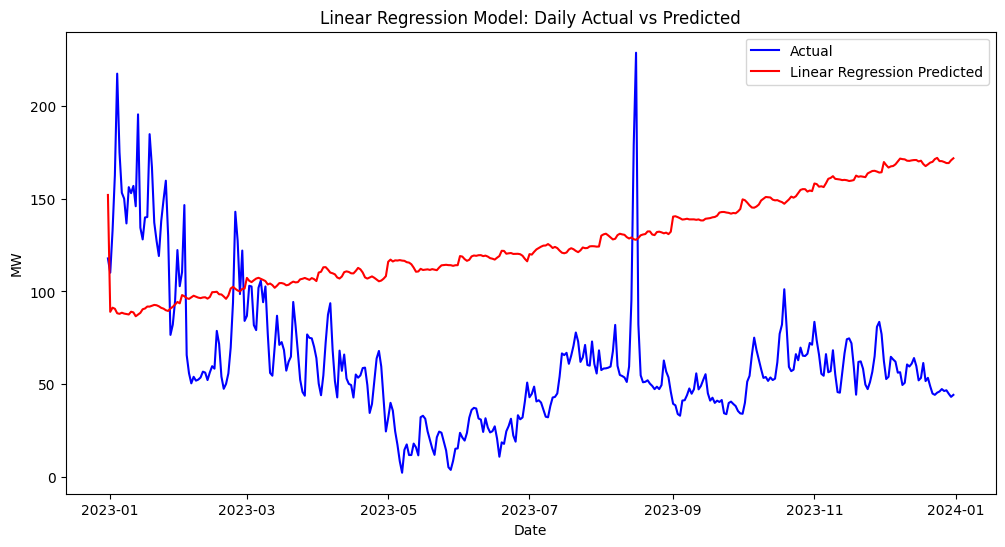

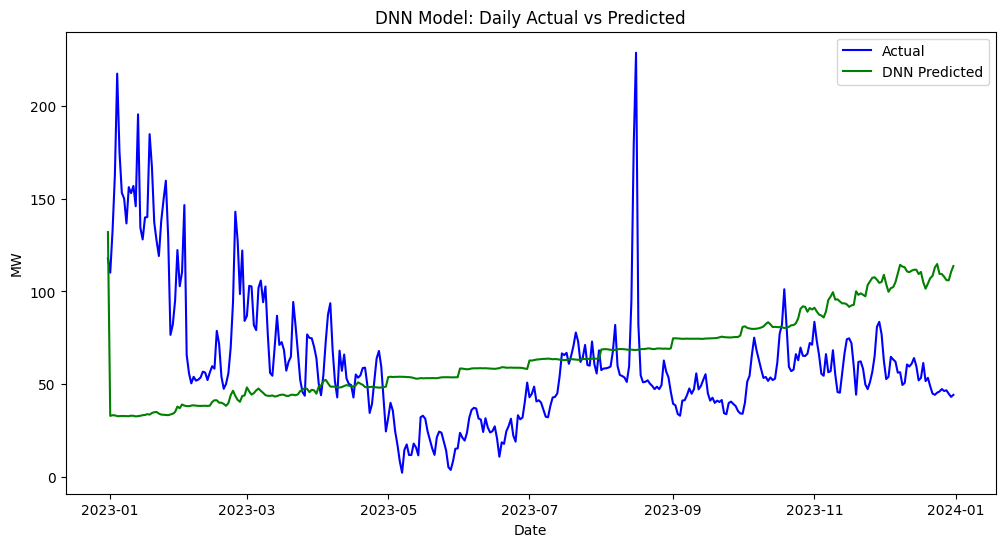

In [10]:
# Predictions from LEAR
lear_predictions = lear_model.predict(X_test)

# Predictions from DNN
dnn_predictions = dnn_model.predict(X_test).flatten()

# Combine datetime, actual, and predicted values in a DataFrame
results_comparison = pd.DataFrame({
    'Datetime': datetime_test,
    'Actual': y_test,
    'LEAR Predictions': lear_predictions,
    'DNN Predictions': dnn_predictions
})

# Convert 'Datetime' to just dates for daily aggregation
results_comparison['Date'] = results_comparison['Datetime'].dt.date

# Group by Date and calculate mean for actual and predicted values
daily_mean = results_comparison.groupby('Date').mean()

# Plotting for LEAR model
plt.figure(figsize=(12, 6))
plt.plot(daily_mean.index, daily_mean['Actual'], label='Actual', color='blue')
plt.plot(daily_mean.index, daily_mean['LEAR Predictions'], label='Linear Regression Predicted', color='red')
plt.title('Linear Regression Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()

# Plotting for DNN model
plt.figure(figsize=(12, 6))
plt.plot(daily_mean.index, daily_mean['Actual'], label='Actual', color='blue')
plt.plot(daily_mean.index, daily_mean['DNN Predictions'], label='DNN Predicted', color='green')
plt.title('DNN Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()